## Parte 3 - IC -IBRA

### Importando bibliotecas básicas

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install xlsxwriter

     |████████████████████████████████| 149 kB 4.1 MB/s 


In [3]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 4.3 MB/s 


In [4]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 4.3 MB/s 
     |████████████████████████████████| 596 kB 47.3 MB/s 
     |████████████████████████████████| 3.3 MB 34.1 MB/s 
     |████████████████████████████████| 895 kB 41.2 MB/s 
     |████████████████████████████████| 59 kB 6.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [5]:
!pip install fairseq fastBPE 

     |████████████████████████████████| 1.7 MB 4.2 MB/s 
     |████████████████████████████████| 90 kB 6.9 MB/s 
     |████████████████████████████████| 145 kB 48.9 MB/s 
     |████████████████████████████████| 112 kB 54.0 MB/s 
     |████████████████████████████████| 74 kB 3.4 MB/s 
  Created wheel for fastBPE: filename=fastBPE-0.1.0-cp37-cp37m-linux_x86_64.whl size=483110 sha256=f17ec4b64e50da72048a0c8fe27498f9f6b45b7137ef88732a7bc69687ddce8a
  Stored in directory: /root/.cache/pip/wheels/bd/d4/0e/0d317a65f77d3f8049fedd8a2ee0519164cf3e6bd77ef886f1
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=19846472249f2b6fa5f2ca6af49f1896dcde966909cc34806ad4a44564251e07
  Stored in directory: /root/.cache/pip/wheels/ca/33/b7/336836125fc9bb4ceaa4376d8abca10ca8bc84ddc824baea6c
Successfully built fastBPE antlr4-python3-runtime


In [6]:
import pandas as pd, numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import StratifiedKFold
import tokenizers
from transformers import RobertaConfig, TFRobertaModel
print('TF version',tf.__version__)

np.random.seed(seed=42)
tf.keras.utils.set_random_seed(42)

TF version 2.7.0


In [7]:
from types import SimpleNamespace
from fairseq.data.encoders.fastbpe import fastBPE
from fairseq.data import Dictionary
from sklearn.utils import shuffle

In [8]:
import json
import tensorflow as tf
import csv
import random
import numpy as np
import sklearn
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import random

In [9]:
!wget https://public.vinai.io/BERTweet_base_transformers.tar.gz
!tar -xzvf BERTweet_base_transformers.tar.gz

--2021-11-18 00:44:42--  https://public.vinai.io/BERTweet_base_transformers.tar.gz
Resolving public.vinai.io (public.vinai.io)... 52.84.225.68, 52.84.225.3, 52.84.225.70, ...
Connecting to public.vinai.io (public.vinai.io)|52.84.225.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322076118 (307M) [application/x-tar]
Saving to: ‘BERTweet_base_transformers.tar.gz’

BERTweet_base_trans 100%[===================>] 307.16M  57.9MB/s    in 5.6s    

2021-11-18 00:44:48 (54.9 MB/s) - ‘BERTweet_base_transformers.tar.gz’ saved [322076118/322076118]

BERTweet_base_transformers/
BERTweet_base_transformers/config.json
BERTweet_base_transformers/bpe.codes
BERTweet_base_transformers/model.bin
BERTweet_base_transformers/dict.txt


In [10]:
class BERTweetTokenizer():
    
    def __init__(self,pretrained_path = '/content/BERTweet_base_transformers/'):
        
        self.bpe = fastBPE(SimpleNamespace(bpe_codes= pretrained_path + "bpe.codes"))
        self.vocab = Dictionary()
        self.vocab.add_from_file(pretrained_path + "dict.txt")
        self.cls_token_id = 0
        self.pad_token_id = 1
        self.sep_token_id = 2
        self.pad_token = '<pad>'
        self.cls_token = '<s>'
        self.sep_token = '</s>'
        
    def bpe_encode(self,text):
        return self.bpe.encode(text) # bpe.encode(line)
    
    def encode(self,text,add_special_tokens=False):
        subwords = self.bpe.encode(text)
        input_ids = self.vocab.encode_line(subwords, append_eos=False, add_if_not_exist=False).long().tolist() ## Map subword tokens to corresponding indices in the dictionary
        return input_ids
    
    def tokenize(self,text):
        return self.bpe_encode(text).split()
    
    def convert_tokens_to_ids(self,tokens):
        input_ids = self.vocab.encode_line(' '.join(tokens), append_eos=False, add_if_not_exist=False).long().tolist()
        return input_ids
    
    #from: https://www.kaggle.com/nandhuelan/bertweet-first-look
    def decode_id(self,id):
        return self.vocab.string(id, bpe_symbol = '@@')
    
    def decode_id_nospace(self,id):
        return self.vocab.string(id, bpe_symbol = '@@ ')

    def bert_encode(self, texts, max_len=512):
        all_tokens = []
        all_masks = []
        all_segments = []
        
        for text in texts:
            text = self.bpe.encode(text)
            input_sequence = '<s> ' + text + ' </s>'

            enc = self.vocab.encode_line(input_sequence, append_eos=False, add_if_not_exist=False).long().tolist()   
            enc = enc[:max_len-2]
            
            pad_len = max_len - len(enc)
            
            tokens = enc + [1] * pad_len #input_ids
            pad_masks = [1] * len(enc) + [0] * pad_len #attention_mask
            segment_ids = [0] * max_len #token_type_ids
            
            all_tokens.append(tokens)
            all_masks.append(pad_masks)
            all_segments.append(segment_ids)
        
        return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [11]:
def build_model(max_len=512):
    PATH = '/content/BERTweet_base_transformers/'
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    config = RobertaConfig.from_pretrained(PATH+'config.json')
    bert_model = TFRobertaModel.from_pretrained(PATH+'model.bin',config=config,from_pt=True)
    x = bert_model(input_word_ids,attention_mask=input_mask,token_type_ids=segment_ids)

    #pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    #clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(64, activation='relu')(x[0]) 
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Flatten()(net)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

    #print(out.shape)
    
    return model

In [ ]:
df = pd.read_csv('/content/drive/Shareddrives/Projeto IBRA USP/Coleta de Dados/Datasets - IBRA/E1 - Hate Speech and Offensive Language/labeled_data.csv', dtype={'Class': int, 'Tweet': str})

df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


### Pre-processing

In [ ]:
# Ver se tem valores nulos de tweet
null_tweets = df[df['tweet'].isna()]

In [ ]:
null_tweets

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet


In [ ]:
# Analisar tamanho dos tweets
df['tweet_len'] = df.tweet.apply(lambda x: len(x))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcf7533b490>]],
      dtype=object)

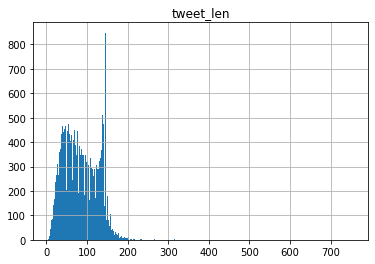

In [ ]:
df.hist('tweet_len', bins=400)

In [ ]:
#df_without_outliers = df[(df.tweet_len > df.tweet_len.quantile(5/1000))]

df_small_outliers = df[df.tweet_len < df.tweet_len.quantile(5/1000)]
df_big_outliers = df[df.tweet_len > df.tweet_len.quantile(995/1000)]

In [ ]:
df_small_outliers.sort_values(by='tweet_len')

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,tweet_len
24364,24869,3,0,3,0,1,pussy,5
23724,24218,3,3,0,0,0,coons,5
24619,25130,6,0,6,0,1,u a hoe,7
21572,22034,3,0,0,3,2,The jig,7
22429,22904,3,0,3,0,1,W bitch,7
...,...,...,...,...,...,...,...,...
9329,9586,3,2,1,0,0,Fucking gook,12
22490,22965,3,0,3,0,1,Watch yo hoe,12
9681,9946,3,1,2,0,1,Hate dat hoe,12
8286,8516,3,1,2,0,1,Call a negro,12


In [ ]:
df_big_outliers.sort_values(by='tweet_len')

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,tweet_len
1295,1323,3,0,2,1,1,&#8220;@HerTruMetier: &#8220;@what_evaittakes:...,193
6134,6311,3,0,3,0,1,@iSkypeYourMomz @TrapGod3sss And I really be t...,193
9027,9279,3,0,3,0,1,"Exes swear they can do better, then you see th...",193
15189,15547,6,1,5,0,1,RT @Fewjr: I don't trust nobody.&#128532;&#128...,193
14272,14614,3,0,3,0,1,RT @BLVKOUT: &#8220;@EMPRESSRAW: &#8220;@Naezu...,194
...,...,...,...,...,...,...,...,...
18886,19305,3,0,3,0,1,RT @digiflorals: bitch do it look like I care ...,455
16539,16918,3,0,0,3,2,RT @Mr_MshkL: &#1589;&#1608;&#1585;&#1577; &#1...,522
1596,1631,3,0,3,0,1,&#8220;@Untouchable_T: Never seen so many perf...,637
13402,13733,3,0,3,0,1,No summer school? &#128515;&#128515;&#128515;&...,657


In [ ]:
df = df.drop(['tweet_len'], axis=1)

## Class Pre-processing
 
Creating the necessary columns to analyze the model.

#### Binary Class to Hate speech

A class will be created that will have a value of 1 if it is offensive language or hate speech, and zero if it is not.


In [12]:
def binaryClassHateSpeech(dataframe, mod=1):
  if(mod == 1): #Put together hate speech and Ofensive language
    dataframe['hate_ofencive_speech'] = dataframe['class'].apply(lambda x: 1 if x!=2 else 0)
  
  if(mod == 2): # It take just the hate speech
    dataframe['hate_ofencive_speech'] = dataframe['class'].apply(lambda x: 1 if x==0 else 0)
  
  return dataframe

In [ ]:
df = binaryClassHateSpeech(df)

In [ ]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,hate_ofencive_speech
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,0
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1


#### Creating collumns with artificial subclassification

In [13]:
def creat_subclass(df, column='hate_ofencive_speech', number_subclasses=3, percent=0.7, seed=10):
  random.seed(seed)
  for i in range(number_subclasses):
    df['subclass' + str(i)] = df['hate_ofencive_speech'].apply(lambda x: 1 if (x==1 and random.random()>percent) else 0)

  return df

In [ ]:
df = creat_subclass(df)

In [ ]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,hate_ofencive_speech,subclass0,subclass1,subclass2
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,0,0,0,0
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1,0,1,1
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1,0,0,0
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1,0,0,0
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1,0,1,0


## Making Samples to the model

In [14]:
# Separate dataset in train and test

def separate_train_and_test(df, class_column ,sub_classes_toTakeOff=[], sub_classes_toKeep=[], seed=42, percent_sample=0.1, sample_index=1):
  train_samples = []
  test_samples = [] # A test_sample it's gonna be all the dataset without a the elementes from train
  
  if sample_index*percent_sample > 1:
    print("ERRO: Invalide sample Index")
    return [], []

  df_without_subclasses = df
  
  # Cut of the subclasses we don't need
  for subclass in sub_classes_toTakeOff:
    df_without_subclasses = df[df[subclass] != 1]

  for subclass in sub_classes_toKeep:
    df_without_subclasses = df[df[subclass] == 1]

  
  df_without_subclasses = shuffle(df_without_subclasses, random_state=seed)
  tam_new_df = df_without_subclasses.shape[0]

  #Getting the samples, doing manual stratification
  df2 = df_without_subclasses[df_without_subclasses[class_column] == 1]
  tam_df2 = df2.shape[0]
  df_train2 = df2[int(percent_sample*tam_df2*(sample_index-1)):int(percent_sample*tam_df2*(sample_index))]
  df_test2  = df.loc[df[class_column] == 1].drop(df_train2.index)

  df3 = df_without_subclasses[df_without_subclasses[class_column] == 0]
  tam_df3 = df3.shape[0]
  df_train3 = df3[int(percent_sample*tam_df3*(sample_index-1)):int(percent_sample*tam_df3*(sample_index))]
  df_test3  = df.loc[df[class_column] == 0].drop(df_train3.index)

  #Juntar
  df_train = pd.concat([df_train3, df_train2])
  df_test = pd.concat([df_test3, df_test2])

  #aleatorizar
  df_train = shuffle(df_train, random_state=seed)
  df_test = shuffle(df_test, random_state=seed)

  return df_train, df_test

In [ ]:
df_train1, df_test = separate_train_and_test(df, 'hate_ofencive_speech',sub_classes_toKeep=['subclass0'])

In [ ]:
df_train1

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,hate_ofencive_speech,subclass0,subclass1,subclass2
23215,23699,6,0,6,0,1,You a hoe and errbody know,1,1,0,1
1438,1468,3,2,1,0,0,&#8220;@NiggaImTatted: Cowboys win games durin...,1,1,0,1
23893,24390,3,0,3,0,1,"happy birthday to my main bitch, my ride or di...",1,1,1,0
10488,10766,3,1,2,0,1,I hate when a bitch got fucked up teeth and sh...,1,1,0,1
9232,9488,3,0,3,0,1,"Fuck all that huggin and kisses, I fuck all th...",1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1512,1544,3,0,2,1,1,&#8220;@SexReIationship: Who else thinks lip b...,1,1,0,1
5438,5596,3,0,3,0,1,"@_ton3zz life aint shit but bitches and money,...",1,1,0,1
4960,5106,3,0,3,0,1,@TheRealJohn_Doe dude fucking mono sucks and m...,1,1,0,1
6995,7191,3,1,2,0,1,@seanlo10s bitch you look like a deformed vers...,1,1,0,1


In [ ]:
df_train2, df_test = separate_train_and_test(df, 'hate_ofencive_speech',sub_classes_toTakeOff=['subclass0'])

In [ ]:
df_train2

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,hate_ofencive_speech,subclass0,subclass1,subclass2
3540,3634,3,0,3,0,1,@ItsmeKyleWayne Yeaa black bitches actin like ...,1,0,0,0
10003,10275,3,0,3,0,1,I almost ran this fine red bitch over.,1,0,0,0
7903,8124,3,0,3,0,1,Bad bitch good head I think she ah keeper !,1,0,0,0
9959,10231,3,0,3,0,1,Hurry up nigga this the last key they dont kno...,1,0,1,1
17281,17676,3,0,2,1,1,RT @SheScreams_Mami: These hoes ain't loyal&#1...,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
16679,17063,3,2,1,0,0,RT @NoHoesNextDoor: If you claim Macklemore is...,1,0,1,0
20136,20581,3,1,2,0,1,RT @the_ironsheik: Justin Bieber win Oscar for...,1,0,0,0
325,330,3,0,3,0,1,"""@djsliime: That long distance shit wack I kne...",1,0,0,0
7543,7757,3,0,3,0,1,Aint no hoe in blood,1,0,1,0


In [ ]:
df.shape

(24783, 11)

In [ ]:
df_train2.shape

(1875, 11)

In [ ]:
df_test.shape

(22908, 11)

#### Separate the validation dataset

In [15]:
def separate_train_validation(df_train, class_column, percent=0.7, seed=12):
   from sklearn.model_selection import train_test_split
   X_t, X_val, y_t, y_val = train_test_split(df_train, df_train[class_column], train_size=percent, random_state=seed)

   return X_t, X_val

## Running the Bertwitter Model

In [ ]:
df_train, df_test = separate_train_and_test(df, 'hate_ofencive_speech',sub_classes_toTakeOff=['subclass0'])

In [ ]:
df_train, df_val = separate_train_validation(df_train, 'hate_ofencive_speech')

In [16]:
#Transform to Numpy
def transform_to_numpy(df, tweet_column, class_column):
  X = df[tweet_column].to_numpy()
  Y = df[class_column].to_numpy()
  return X, Y

In [ ]:
X_train, Y_train = transform_to_numpy(df_train, 'tweet', 'hate_ofencive_speech')

X_test, Y_test = transform_to_numpy(df_test, 'tweet', 'hate_ofencive_speech')

X_val, Y_val = transform_to_numpy(df_val, 'tweet', 'hate_ofencive_speech')

In [17]:
def class_size_graph(Y_train,Y_test, Y_val):
  labels = ["%s"%i for i in range(3)]

  unique, counts = np.unique(Y_train, return_counts=True)
  uniquet, countst = np.unique(Y_test, return_counts=True)
  uniquev, countsv = np.unique(Y_val, return_counts=True)

  fig, ax = plt.subplots()
  rects3 = ax.bar(uniquev - 0.5, countsv, 0.25, label='Validation')
  rects1 = ax.bar(unique - 0.2, counts, 0.25, label='Train')
  rects2 = ax.bar(unique + 0.1, countst, 0.25, label='Test')
  ax.legend()
  ax.set_xticks(unique)
  ax.set_xticklabels(labels)

  plt.title('Hate Speech classes')
  plt.xlabel('Class')
  plt.ylabel('Frequency')
  plt.show()

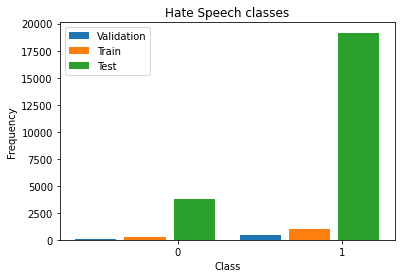

In [ ]:
class_size_graph(Y_train,Y_test, Y_val)

In [18]:
#Tokenização
max_len = 32

tokenizer = BERTweetTokenizer()
#fit

In [ ]:
model = build_model(max_len=max_len)
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 32)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 32)]         0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 32)]         0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  134899968  ['input_word_ids[0][0]',         
 el)                            thPoolingAndCrossAt               'input_mask[0][0]',         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
train_history = model.fit(
    X_train, Y_train, 
    validation_data=(X_val, Y_val),
    epochs=3,
    batch_size=16,
    verbose=1
)
#model.save_weights('savefile')

Epoch 1/3
82/82 [==============================] - 41s 345ms/step - loss: 0.5623 - accuracy: 0.7287 - val_loss: 0.4728 - val_accuracy: 0.7904
Epoch 2/3
82/82 [==============================] - 25s 302ms/step - loss: 0.4448 - accuracy: 0.7820 - val_loss: 0.3423 - val_accuracy: 0.8046
Epoch 3/3
82/82 [==============================] - 25s 302ms/step - loss: 0.2692 - accuracy: 0.8887 - val_loss: 0.1985 - val_accuracy: 0.9254


In [ ]:
# Running the model to the Test dataframe
X_test = tokenizer.bert_encode(X_test, max_len=max_len)
P_hat = model.predict(X_test)

In [ ]:
P_hat[:20]

array([[0.99435234],
       [0.9907031 ],
       [0.98782   ],
       [0.41682598],
       [0.98611414],
       [0.9939003 ],
       [0.9946849 ],
       [0.99042964],
       [0.9744005 ],
       [0.9954444 ],
       [0.9930738 ],
       [0.5338765 ],
       [0.98970455],
       [0.9929497 ],
       [0.22997397],
       [0.9939505 ],
       [0.22745821],
       [0.9910909 ],
       [0.35179886],
       [0.25886273]], dtype=float32)

## Analyzing the result

In [19]:
def plot_confusion_matrix(y, y_pred, beta = 2):
    """
    It receives an array with the ground-truth (y)
    and another with the prediction (y_pred), both with binary labels
    (positve=+1 and negative=-1) and plots the confusion
    matrix.
    It uses P (positive class id) and N (negative class id)
    which are "global" variables ...
    """
    TP = np.sum((y_pred == 1) * (y == 1))
    TN = np.sum((y_pred == 0) * (y == 0))

    FP = np.sum((y_pred == 1) * (y == 0))
    FN = np.sum((y_pred == 0) * (y == 1))

    total = TP+FP+TN+FN

    accuracy = (TP+TN)/total
    recall = (TP)/(TP+FN)
    precision = (TP)/(TP+FP)

    Fbeta = (precision*recall)*(1+beta**2)/(beta**2*precision + recall)
    
    print("TP = %4d    FP = %4d\nFN = %4d    TN = %4d\n"%(TP,FP,FN,TN))
    print("Accuracy = %d / %d (%f)" %((TP+TN),total, (TP+TN)/total))
    print("Recall = %d / %d (%f)" %((TP),(TP+FN), (TP)/(TP+FN)))
    print("Precision = %d / %d (%f)" %((TP),(TP+FP), (TP)/(TP+FP)))
    print("Fbeta Score = %f" %(Fbeta))

    confusion = [
        [TP/(TP+FN), FP/(TN+FP)],
        [FN/(TP+FN), TN/(TN+FP)]
    ]

    P = 1
    N = 0

    df_cm = pd.DataFrame(confusion, \
                         ['$\hat{y} = %d$'%P, '$\hat{y} = %d$'%N],\
                         ['$y = %d$'%P, '$y = %d$'%N])
    
    plt.figure(figsize = (8,4))
    sb.set(font_scale=1.4)
    sb.heatmap(df_cm, annot=True) #, annot_kws={"size": 16}, cmap = 'coolwarm')
    plt.show()

TP = 18283    FP =  906
FN =  878    TN = 2841
Accuracy = 21124 / 22908 (0.922123)

Recall = 18283 / 19161 (0.954178)



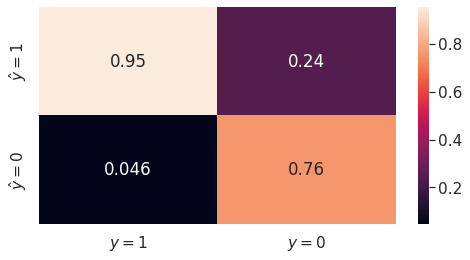

In [ ]:
threshold = 0.55

y_hat = np.where(P_hat > threshold, 1, 0)
y_test = Y_test.reshape([Y_test.shape[0], 1])

total = len(y_hat)

plot_confusion_matrix(y_test, y_hat)   

In [ ]:
def recall(y, y_pred):
    TP = np.sum((y_pred == 1) * (y == 1))
    TN = np.sum((y_pred == 0) * (y == 0))

    FP = np.sum((y_pred == 1) * (y == 0))
    FN = np.sum((y_pred == 0) * (y == 1))

    total = TP+FP+TN+FN

    recall = (TP)/(TP+FN)

    return recall

In [20]:
def plot_threshold_recall(Y_test, P_hat, step_size=0.05):
  recalls = []
  thresholds = []
  i = 0.2
  Y_test = Y_test.reshape([Y_test.shape[0], 1])

  while i < 0.95:
    threshold = i

    Y_hat = np.where(P_hat > threshold, 1, 0)
    
    recalls.append(recall(Y_test, Y_hat))
    thresholds.append(threshold)
    i += step_size

  plt.plot(thresholds, recalls)

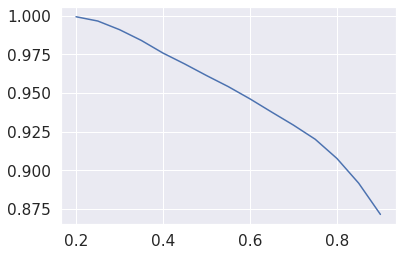

In [ ]:
plot_threshold_recall(Y_test, P_hat, step_size=0.05)

### Put all the process together

In [21]:
def train_model(df_train, df_test, df_val, xColumn, yColumn):

  # Pass to numpy array
  X_train, Y_train = transform_to_numpy(df_train, xColumn, yColumn)
  X_test, Y_test = transform_to_numpy(df_test, xColumn, yColumn)
  X_val, Y_val = transform_to_numpy(df_val, xColumn, yColumn)
  
  #Tokenização
  max_len = 32

  tokenizer = BERTweetTokenizer()
  X_train = tokenizer.bert_encode(X_train, max_len=max_len)
  X_val = tokenizer.bert_encode(X_val, max_len=max_len)

  # Train the model
  model = build_model(max_len=max_len)
  model.summary()
  train_history = model.fit(
    X_train, Y_train, 
    validation_data=(X_val, Y_val),
    epochs=3,
    batch_size=16,
    verbose=1
  )
  model.save_weights('savefile')

  # Running the model to the Test dataframe
  X_test = tokenizer.bert_encode(X_test, max_len=max_len)
  P_hat = model.predict(X_test)

  return P_hat

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/IME/IC/datasets/D1-original.csv', dtype={'Class': int, 'Tweet': str})
df = binaryClassHateSpeech(df, mod=2) #let's try just with hate speech
df = creat_subclass(df)


In [ ]:
# Separate train, test and validation
df_train, df_test = separate_train_and_test(df, 'hate_ofencive_speech',sub_classes_toTakeOff=['subclass0'])
df_train, df_val = separate_train_validation(df_train, 'hate_ofencive_speech')


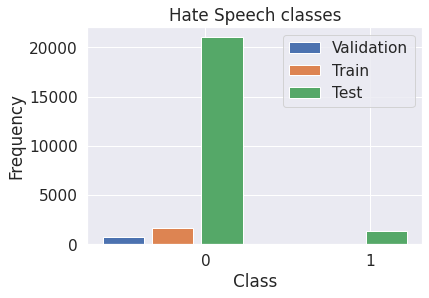

In [ ]:
# Print confusion matriz:]
X_train, Y_train = transform_to_numpy(df_train, 'tweet', 'hate_ofencive_speech')
X_test, Y_test = transform_to_numpy(df_test, 'tweet', 'hate_ofencive_speech')
X_val, Y_val = transform_to_numpy(df_val, 'tweet', 'hate_ofencive_speech')

class_size_graph(Y_train, Y_test, Y_val)

In [ ]:
P_hat = train_model(df_train, df_test, df_val, 'tweet', 'hate_ofencive_speech')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.
/usr/local/lib/python3.7/dist-packages/keras/opt

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 32)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 32)]         0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 32)]         0           []                               
                                                                                                  
 tf_roberta_model_1 (TFRobertaM  TFBaseModelOutputWi  134899968  ['input_word_ids[0][0]',         
 odel)                          thPoolingAndCrossAt               'input_mask[0][0]',       

TP =    0    FP =    0
FN = 1329    TN = 21018
Accuracy = 21018 / 22347 (0.940529)

Recall = 0 / 1329 (0.000000)



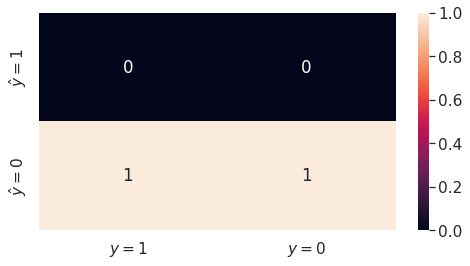

In [ ]:
# Print confusion matriz:]

threshold = 0.55

Y_hat = np.where(P_hat > threshold, 1, 0)
Y_test = Y_test.reshape([Y_test.shape[0], 1])

total = len(Y_hat)

plot_confusion_matrix(Y_test, Y_hat)  

# Analizing a new dataset (**E9**)

### Pre-processing

In [22]:
test_df = pd.read_csv('/content/drive/Shareddrives/Projeto IBRA USP/Coleta de Dados/Datasets - IBRA/collected_tweets/NAACL_SRW_2016.csv')#, encoding = 'latin-1')
test_label_df = pd.read_csv('/content/drive/Shareddrives/Projeto IBRA USP/Coleta de Dados/Datasets - IBRA/collected_tweets/NAACL_SRW_2016Labels.csv', header = None)
df = pd.concat([test_df,test_label_df], axis = 1)
df.columns = ['tweet','class']
df = df.dropna()
df.head()

,tweet,class
0,These girls are the equivalent of the irritati...,racism
1,Drasko they didn't cook half a bird you idiot ...,racism
2,Hopefully someone cooks Drasko in the next ep ...,racism
3,of course you were born in serbia...you're as ...,racism
4,So Drasko just said he was impressed the girls...,racism


In [23]:
pd.unique(df['class'])

array(['racism', 'sexism', 'none'], dtype=object)

In [24]:
df['hate_speech'] = df['class'].apply(lambda x : 0 if x=='none' else 1)
df['racism'] = df['class'].apply(lambda x : 1 if x=='racism' else 0)
df['sexism'] = df['class'].apply(lambda x : 1 if x=='sexism' else 0)

In [25]:
df.head()


,tweet,class,hate_speech,racism,sexism
0,These girls are the equivalent of the irritati...,racism,1,1,0
1,Drasko they didn't cook half a bird you idiot ...,racism,1,1,0
2,Hopefully someone cooks Drasko in the next ep ...,racism,1,1,0
3,of course you were born in serbia...you're as ...,racism,1,1,0
4,So Drasko just said he was impressed the girls...,racism,1,1,0


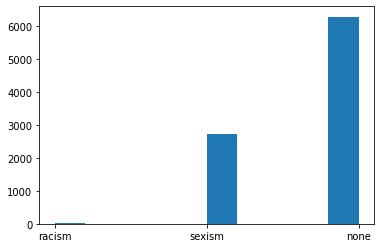

In [26]:
plt.hist(df['class'])
plt.show()

In [27]:
len(df[df['class'] == 'racism'])

12

In [30]:
len(df[df['class'] == 'sexism'])

2711

In [31]:
len(df[df['class'] == 'none'])

6271

In [ ]:
for i in range(10):
  print(df['tweet'][i] + '\n')

These girls are the equivalent of the irritating Asian girls a couple years ago. Well done, 7. #MKR

Drasko they didn't cook half a bird you idiot #mkr

Hopefully someone cooks Drasko in the next ep of #MKR

of course you were born in serbia...you're as fucked as A Serbian Film #MKR

So Drasko just said he was impressed the girls cooked half a chicken.. They cooked a whole one  #MKR

I've had better looking shits than these two! #MKR2015 #MKR #killerblondes

The face of very ugly promo girls ! Faces like cats arsehole #mkr excited to see them@go down tonight...literally http://t.co/HgoJrfoIeO

@mykitchenrules Elegant and beautiful?Cheap and trashy!Nothing more unattractive than girls banging on about how hot hey are. #mkr #notsassy

"He can't be a server at our restaurant, that beard makes him look like a terrorist." Everyone laughs. #fuckthanksgiving

Stop saying dumb blondes with pretty faces as you need a pretty face to pull that off!!!! #mkr



### Running the model 

In [32]:
"""
Training with a sample of sexism
"""

# Separate train, test and validation
#def separate_train_and_test(df, class_column ,sub_classes_toTakeOff=[], sub_classes_toKeep=[], seed=42, percent_sample=0.1, sample_index=1):

df_train, df_test = separate_train_and_test(df, 'hate_speech',sub_classes_toTakeOff=['racism'])
df_train, df_val = separate_train_validation(df_train, 'hate_speech')

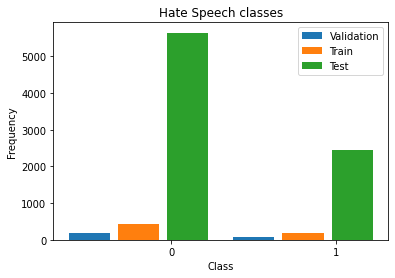

In [33]:
# Print confusion matriz:]
X_train, Y_train = transform_to_numpy(df_train, 'tweet', 'hate_speech')
X_test, Y_test = transform_to_numpy(df_test, 'tweet', 'hate_speech')
X_val, Y_val = transform_to_numpy(df_val, 'tweet', 'hate_speech')

class_size_graph(Y_train, Y_test, Y_val)

In [34]:
print(len(df_train), len(df_test), len(df_val))
print(len(df_train[df_train['hate_speech']== 1]), len(df_test[df_test['hate_speech'] == 1]), len(df_val[df_val['hate_speech']==1]))

628 8096 270
196 2452 75


In [37]:
P_hat, model = train_model2(df_train, df_test, df_val, 'tweet', 'hate_speech')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.
/usr/local/lib/python3.7/dist-packages/keras/opt

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 32)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 32)]         0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 32)]         0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  134899968  ['input_word_ids[0][0]',         
 el)                            thPoolingAndCrossAt               'input_mask[0][0]',         

TP =  110    FP =    3
FN = 2342    TN = 5641

Accuracy = 5751 / 8096 (0.710351)
Recall = 110 / 2452 (0.044861)
Precision = 110 / 113 (0.973451)
Fbeta Score = 0.055438


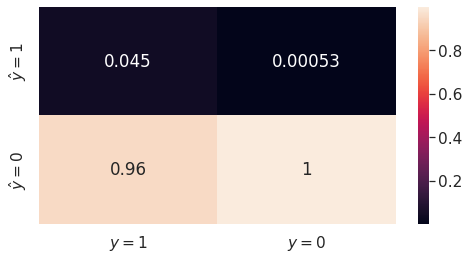

In [38]:
# Print confusion matriz:]

threshold = 0.55

Y_hat = np.where(P_hat > threshold, 1, 0)
Y_test = Y_test.reshape([Y_test.shape[0], 1])

total = len(Y_hat)

plot_confusion_matrix(Y_test, Y_hat)  

### Increaing the size of the sample

In [36]:
def train_model2(df_train, df_test, df_val, xColumn, yColumn):

  # Pass to numpy array
  X_train, Y_train = transform_to_numpy(df_train, xColumn, yColumn)
  X_test, Y_test = transform_to_numpy(df_test, xColumn, yColumn)
  X_val, Y_val = transform_to_numpy(df_val, xColumn, yColumn)
  
  #Tokenização
  max_len = 32
  tokenizer = BERTweetTokenizer()
  X_train = tokenizer.bert_encode(X_train, max_len=max_len)
  X_val = tokenizer.bert_encode(X_val, max_len=max_len)

  # Train the model
  model = build_model(max_len=max_len)
  model.summary()
  train_history = model.fit(
    X_train, Y_train, 
    validation_data=(X_val, Y_val),
    epochs=3,
    batch_size=16,
    verbose=1
  )
  model.save_weights('savefile')

  # Running the model to the Test dataframe
  X_test = tokenizer.bert_encode(X_test, max_len=max_len)
  P_hat = model.predict(X_test)

  return P_hat, model

In [39]:
"""
Training with a sample of sexism
"""

# Separate train, test and validation
#def separate_train_and_test(df, class_column ,sub_classes_toTakeOff=[], sub_classes_toKeep=[], seed=42, percent_sample=0.1, sample_index=1):

df_train, df_test = separate_train_and_test(df, 'hate_speech',sub_classes_toTakeOff=['racism'],percent_sample=0.5)
df_train, df_val = separate_train_validation(df_train, 'hate_speech')

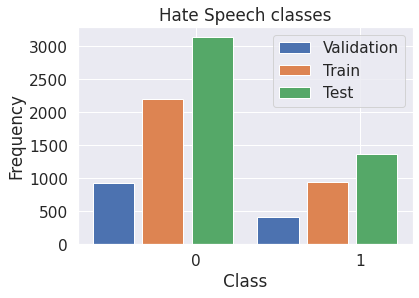

In [40]:
# Print confusion matriz:]
X_train, Y_train = transform_to_numpy(df_train, 'tweet', 'hate_speech')
X_test, Y_test = transform_to_numpy(df_test, 'tweet', 'hate_speech')
X_val, Y_val = transform_to_numpy(df_val, 'tweet', 'hate_speech')

class_size_graph(Y_train, Y_test, Y_val)

In [41]:
print(len(df_train), len(df_test), len(df_val))
print(len(df_train[df_train['hate_speech']== 1]), len(df_test[df_test['hate_speech'] == 1]), len(df_val[df_val['hate_speech']==1]))

3143 4504 1347
941 1368 414


In [42]:
P_hat, model2 = train_model2(df_train, df_test, df_val, 'tweet', 'hate_speech')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.
/usr/local/lib/python3.7/dist-packages/keras/opt

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 32)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 32)]         0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 32)]         0           []                               
                                                                                                  
 tf_roberta_model_1 (TFRobertaM  TFBaseModelOutputWi  134899968  ['input_word_ids[0][0]',         
 odel)                          thPoolingAndCrossAt               'input_mask[0][0]',       

TP =  936    FP =  274
FN =  432    TN = 2862

Accuracy = 3798 / 4504 (0.843250)
Recall = 936 / 1368 (0.684211)
Precision = 936 / 1210 (0.773554)
Fbeta Score = 0.700389


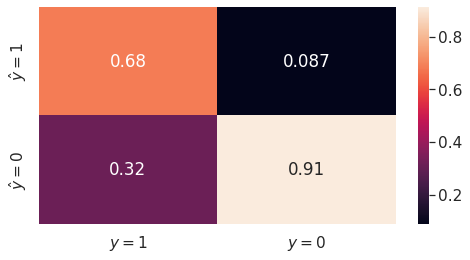

In [43]:
# Print confusion matriz:]

threshold = 0.55

Y_hat = np.where(P_hat > threshold, 1, 0)
Y_test = Y_test.reshape([Y_test.shape[0], 1])

total = len(Y_hat)

plot_confusion_matrix(Y_test, Y_hat)  

Testing the model with other dataset

In [44]:
df_E1 = pd.read_csv('/content/drive/MyDrive/IME/IC/datasets/D1-original.csv', dtype={'Class': int, 'Tweet': str})
df_E1 = binaryClassHateSpeech(df_E1, mod=1) #let's try just with hate speech

In [45]:
X_test, Y_test = transform_to_numpy(df_E1, 'tweet', 'hate_ofencive_speech')

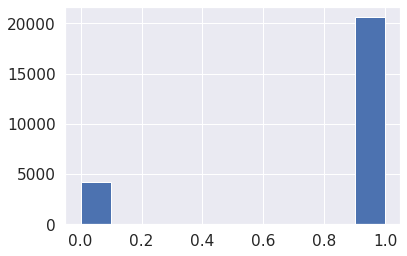

In [46]:
plt.hist(Y_test)
plt.show()

Amostra de 10% dos casos de machismo

In [47]:
#Tokenização
max_len = 32
tokenizer = BERTweetTokenizer()
X_test = tokenizer.bert_encode(X_test, max_len=max_len)
P_hat = model.predict(X_test)

TP =  184    FP =   55
FN = 20436    TN = 4108

Accuracy = 4292 / 24783 (0.173183)
Recall = 184 / 20620 (0.008923)
Precision = 184 / 239 (0.769874)
Fbeta Score = 0.011122


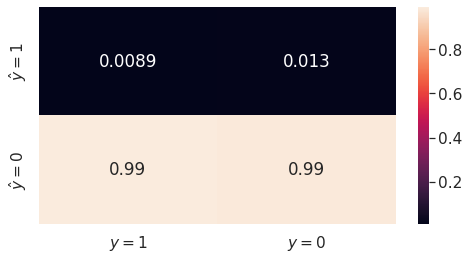

In [48]:
threshold = 0.50

Y_hat = np.where(P_hat > threshold, 1, 0)
Y_test = Y_test.reshape([Y_test.shape[0], 1])

total = len(Y_hat)

plot_confusion_matrix(Y_test, Y_hat) 

Amostra de 50% dos casos de machismo

In [49]:
#Tokenização
P_hat = model2.predict(X_test)

TP = 10397    FP =  935
FN = 10223    TN = 3228

Accuracy = 13625 / 24783 (0.549772)
Recall = 10397 / 20620 (0.504219)
Precision = 10397 / 11332 (0.917490)
Fbeta Score = 0.554140


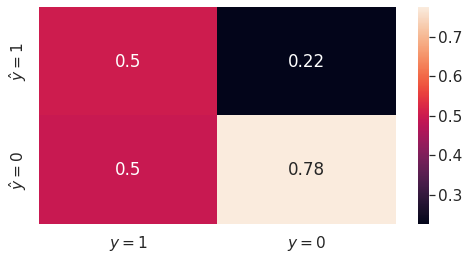

In [50]:
# Print confusion matriz:]

threshold = 0.50

Y_hat = np.where(P_hat > threshold, 1, 0)
Y_test = Y_test.reshape([Y_test.shape[0], 1])

total = len(Y_hat)

plot_confusion_matrix(Y_test, Y_hat) 